<a href="https://colab.research.google.com/github/Sinamhd9/A-Pipeline-for-Enhanced-Multimodal-Imaging-of-Structural-Concrete/blob/main/generative%20adversarial%20networks/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative adverserial network (GAN)

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, InputLayer, Flatten, Conv2DTranspose, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import pandas as pd

## Fashion MNIST data

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


### Visualization

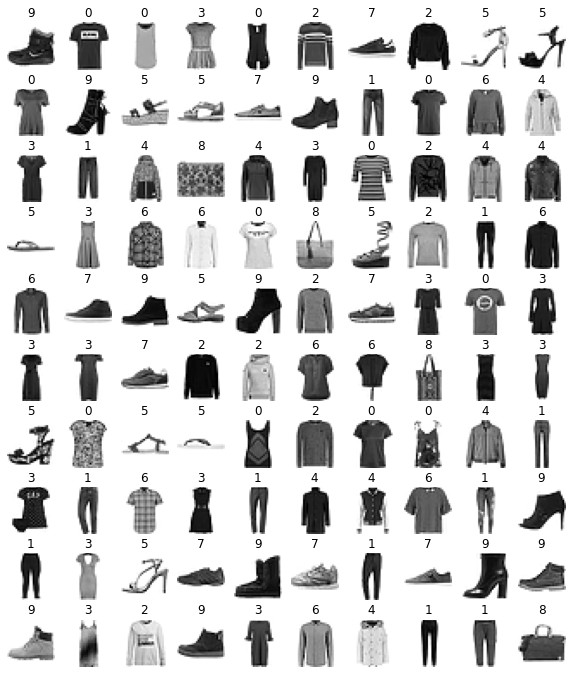

In [ ]:
n = 100
fig, axs = plt.subplots(10, 10, figsize=(10, 12))
axs = axs.ravel()

for i in range(n):
  axs[i].imshow(x_train[i], cmap='gray_r')
  axs[i].set_title(y_train[i])
  axs[i].axis('off')


## Dense GAN model

### Generator

Based on the instructions and some trial and error, I ended up with this architecture consisting of several dense , Leaky relu , batch norm, and dropout blocks. 

In [ ]:
def generator_model(input_dim):
  model = Sequential ([
                       Dense(100, activation=LeakyReLU(), input_shape=(input_dim,)),
                       BatchNormalization(),
                       Dense(256, activation=LeakyReLU()),
                       BatchNormalization(),
                       Dropout(0.2),
                       Dense(512, activation=LeakyReLU()),
                       BatchNormalization(),
                       Dropout(0.2),
                       Dense(1024, activation=LeakyReLU()),
                       BatchNormalization(),
                       Dropout(0.2),
                       Dense(784, 'sigmoid'),
                       Reshape((28, 28))
                       ])
  return model

### Discriminator

Same here, several Dense, dropout layers without Batchnorms. 

In [ ]:
def discriminator_model(input_dim):
  model = Sequential ([
                            InputLayer(input_dim),
                            Flatten(),
                            Dense (1024, activation=LeakyReLU()),
                            Dropout(0.2),
                            Dense (512, activation=LeakyReLU()),
                            Dropout(0.2),
                            Dense (256, activation=LeakyReLU()),
                            Dropout(0.2),
                            Dense(1, 'sigmoid'),
                       ])
  model.compile(optimizer = Adam(learning_rate= 0.0001, beta_1 = 0.9), loss='binary_crossentropy')
  return model

### GAN Model

Simply connecting generator and discriminator and freezing the weights of the discriminator.

In [ ]:
def gan_model(gen, disc):
  disc.trainable = False
  model = Sequential([
                      gen,
                      disc
                      ])
  model.compile(optimizer = Adam(learning_rate= 0.0001, beta_1 = 0.9), loss= 'binary_crossentropy')
  return model


### Preprocessing

Chanding the range of the data to 0 and 1, turning them to float32 and adding an extra axis to feed them to the network

In [ ]:
def preprocess(data):
  return np.expand_dims((data/255).astype('float32') , axis=-1)

Getting real images randomly from the dataset

In [ ]:
def get_realData(data, n):
  ix = np.random.randint(0, data.shape[0], size=n)
  return data[ix]

Generate noise based on normal distribution

In [ ]:
def generate_noise(n, dim = 100):
  noise = np.zeros((n, dim))
  for i in range(n):
    noise[i]= np.random.randn(dim)
  return noise

Output of the generator when fed with noise to generate fake examples

In [ ]:
def generate_fake(generator, noise):
  fake_images = generator.predict(noise)
  return fake_images

### Training

Training function, saving all losses of batches, and plotting the generated images every 10 epochs

In [ ]:
def train(gan, gen, disc, data, dim = 100, max_epochs=100, batch_size=128):
  n_batches = int(data.shape[0] / batch_size)
  n_batches_half = int(n_batches / 2)
  dis_loss_real_all = []
  dis_loss_fake_all = []
  gan_loss_all = []
  for i in range(max_epochs):
    for j in range(n_batches):
      x_real = get_realData(data, n_batches_half)
      y_real = np.ones((n_batches_half, 1))
      disc_loss_real = disc.train_on_batch(x_real, y_real)
      noise_input = generate_noise(n_batches_half, dim)
      x_fake = generate_fake(gen, noise_input)
      y_fake = np.zeros((n_batches_half, 1))
      disc_loss_fake = disc.train_on_batch(x_fake, y_fake)
      x_gan = generate_noise(n_batches, dim)
      y_gan = np.ones((n_batches, 1))
      gan_loss = gan.train_on_batch(x_gan, y_gan)
      dis_loss_real_all.append(disc_loss_real)
      dis_loss_fake_all.append(disc_loss_fake)
      gan_loss_all.append(gan_loss)
    print(f'epoch: {i}, discriminator loss real: {disc_loss_real}, discriminator loss fake: {disc_loss_fake}, gan loss: {gan_loss}')
    if (i%10 == 0):
      pred = gen.predict(x_gan)
      sample_images = pred.reshape(n_batches, 28, 28)[:100]
      n = 100
      fig, axs = plt.subplots(10, 10, figsize=(10, 12))
      axs = axs.ravel()
      for z in range(n):
        axs[z].imshow(sample_images[z], cmap='gray_r')
        axs[z].axis('off')
      plt.show()
  K.clear_session()
  return {'gan_loss': gan_loss_all, 'dis_loss_real': dis_loss_real_all, 'dis_loss_fake': dis_loss_fake_all}

In [ ]:
data = preprocess(x_train)
print(data.shape)

(60000, 28, 28, 1)


In [ ]:
input_dim_disc = (28, 28, 1)
discriminator = discriminator_model(input_dim_disc)
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [ ]:
input_dim_gen = 100
generator = generator_model(input_dim_gen)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)              

In [ ]:
gan = gan_model(generator, discriminator)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28)            1504020   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1460225   
Total params: 2,964,245
Trainable params: 1,500,236
Non-trainable params: 1,464,009
_________________________________________________________________


### Results of Dense GAN model

Loss of discriminator on every epoch is shown on both fake and real examples, as well as the loss of the whole GAN model. We can see it is somehow reaching an equilibrium and making better fake images. 

epoch: 0, discriminator loss real: 0.013989653438329697, discriminator loss fake: 0.01356272678822279, gan loss: 8.052660942077637


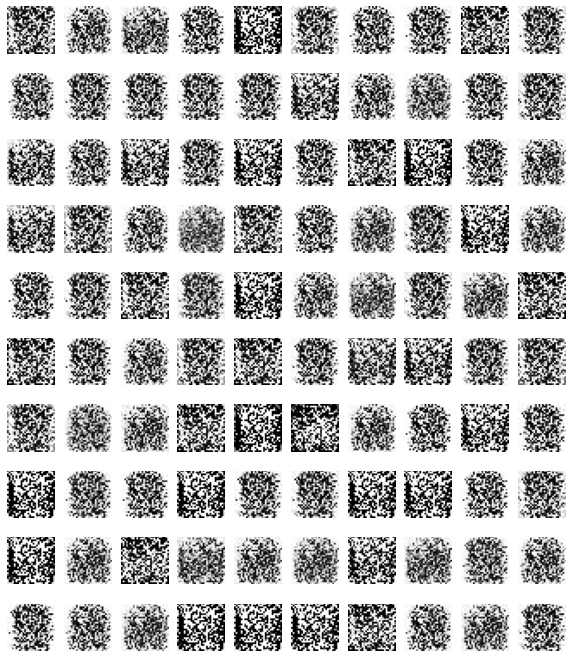

epoch: 1, discriminator loss real: 0.04409203305840492, discriminator loss fake: 0.022335732355713844, gan loss: 10.107987403869629
epoch: 2, discriminator loss real: 0.008984602056443691, discriminator loss fake: 0.011120088398456573, gan loss: 5.4566779136657715
epoch: 3, discriminator loss real: 0.1999635398387909, discriminator loss fake: 0.04133661091327667, gan loss: 5.920900344848633
epoch: 4, discriminator loss real: 0.06098143383860588, discriminator loss fake: 0.13256195187568665, gan loss: 6.134099006652832
epoch: 5, discriminator loss real: 0.13636749982833862, discriminator loss fake: 0.06343960762023926, gan loss: 6.354913711547852
epoch: 6, discriminator loss real: 0.278190553188324, discriminator loss fake: 0.10786526650190353, gan loss: 3.713224172592163
epoch: 7, discriminator loss real: 0.3380034267902374, discriminator loss fake: 0.2598971426486969, gan loss: 2.8216145038604736
epoch: 8, discriminator loss real: 0.42774203419685364, discriminator loss fake: 0.348092

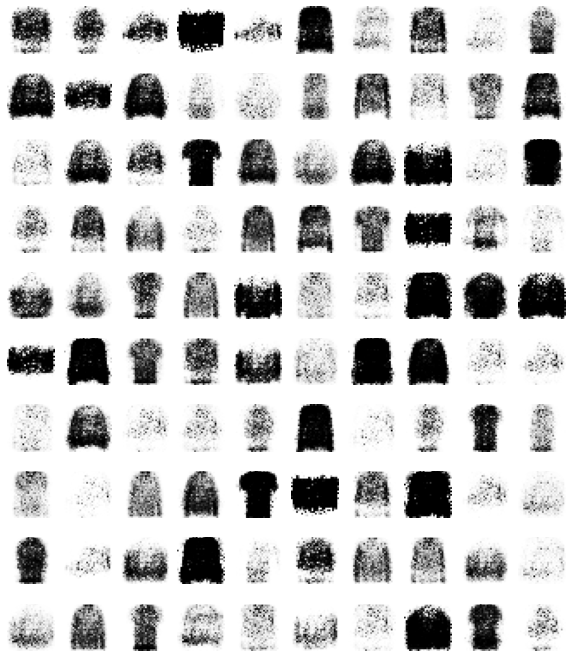

epoch: 11, discriminator loss real: 0.40186262130737305, discriminator loss fake: 0.2964102625846863, gan loss: 2.2012672424316406
epoch: 12, discriminator loss real: 0.4195006191730499, discriminator loss fake: 0.26816850900650024, gan loss: 2.3256149291992188
epoch: 13, discriminator loss real: 0.37188059091567993, discriminator loss fake: 0.28215673565864563, gan loss: 2.544015884399414
epoch: 14, discriminator loss real: 0.4373966157436371, discriminator loss fake: 0.2829909324645996, gan loss: 2.489704132080078
epoch: 15, discriminator loss real: 0.38203537464141846, discriminator loss fake: 0.29700255393981934, gan loss: 2.0348923206329346
epoch: 16, discriminator loss real: 0.396279513835907, discriminator loss fake: 0.2973180413246155, gan loss: 2.096970558166504
epoch: 17, discriminator loss real: 0.5726452469825745, discriminator loss fake: 0.33407050371170044, gan loss: 1.9564114809036255
epoch: 18, discriminator loss real: 0.49968308210372925, discriminator loss fake: 0.343

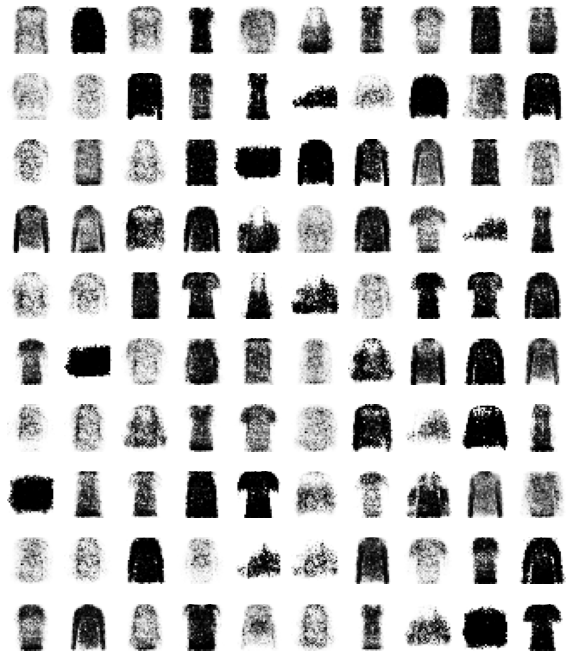

epoch: 21, discriminator loss real: 0.5548157691955566, discriminator loss fake: 0.322995126247406, gan loss: 1.923964262008667
epoch: 22, discriminator loss real: 0.4396865963935852, discriminator loss fake: 0.4228605031967163, gan loss: 1.6723151206970215
epoch: 23, discriminator loss real: 0.4850027561187744, discriminator loss fake: 0.49966850876808167, gan loss: 1.5593678951263428
epoch: 24, discriminator loss real: 0.48756977915763855, discriminator loss fake: 0.45250171422958374, gan loss: 1.5650900602340698
epoch: 25, discriminator loss real: 0.5452073216438293, discriminator loss fake: 0.3121268153190613, gan loss: 1.7532802820205688
epoch: 26, discriminator loss real: 0.4016590416431427, discriminator loss fake: 0.46208444237709045, gan loss: 1.7429711818695068
epoch: 27, discriminator loss real: 0.4153735637664795, discriminator loss fake: 0.4148237705230713, gan loss: 1.6417515277862549
epoch: 28, discriminator loss real: 0.5042394995689392, discriminator loss fake: 0.43726

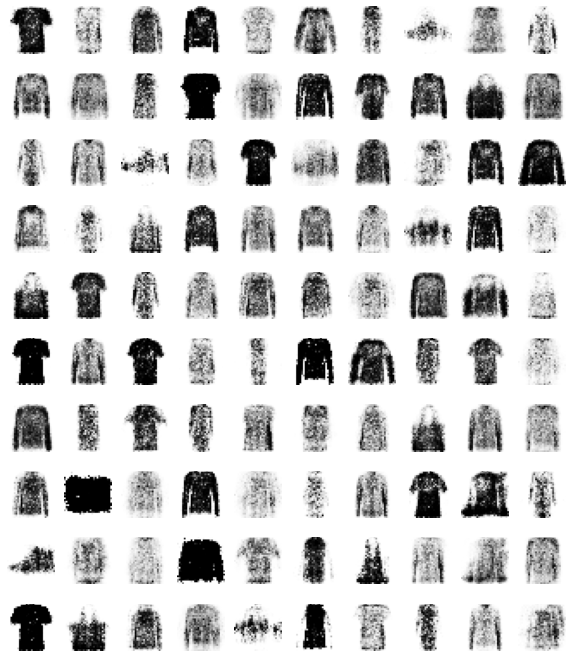

epoch: 31, discriminator loss real: 0.3987801671028137, discriminator loss fake: 0.34001097083091736, gan loss: 1.7203682661056519
epoch: 32, discriminator loss real: 0.5951528549194336, discriminator loss fake: 0.51702481508255, gan loss: 1.4550920724868774
epoch: 33, discriminator loss real: 0.38699206709861755, discriminator loss fake: 0.3444058299064636, gan loss: 1.6239302158355713
epoch: 34, discriminator loss real: 0.4593965709209442, discriminator loss fake: 0.406357079744339, gan loss: 1.430876612663269
epoch: 35, discriminator loss real: 0.4016224443912506, discriminator loss fake: 0.3460891544818878, gan loss: 1.7497920989990234
epoch: 36, discriminator loss real: 0.4995065927505493, discriminator loss fake: 0.4601585268974304, gan loss: 1.3826944828033447
epoch: 37, discriminator loss real: 0.5330346822738647, discriminator loss fake: 0.46530088782310486, gan loss: 1.4591150283813477
epoch: 38, discriminator loss real: 0.641749918460846, discriminator loss fake: 0.455925792

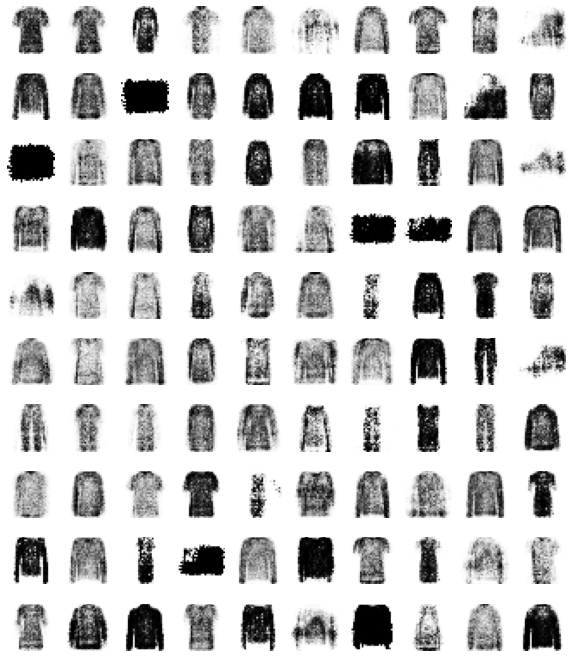

epoch: 41, discriminator loss real: 0.46008938550949097, discriminator loss fake: 0.3884188234806061, gan loss: 1.4429662227630615
epoch: 42, discriminator loss real: 0.38898056745529175, discriminator loss fake: 0.34143468737602234, gan loss: 1.8511383533477783
epoch: 43, discriminator loss real: 0.5828995108604431, discriminator loss fake: 0.619901180267334, gan loss: 1.2825177907943726
epoch: 44, discriminator loss real: 0.494326651096344, discriminator loss fake: 0.4725789427757263, gan loss: 1.4186313152313232
epoch: 45, discriminator loss real: 0.4364736080169678, discriminator loss fake: 0.4887428283691406, gan loss: 1.5266519784927368
epoch: 46, discriminator loss real: 0.5398797392845154, discriminator loss fake: 0.5124503970146179, gan loss: 1.378857970237732
epoch: 47, discriminator loss real: 0.5050747394561768, discriminator loss fake: 0.6151498556137085, gan loss: 1.2006419897079468
epoch: 48, discriminator loss real: 0.4193776249885559, discriminator loss fake: 0.3629445

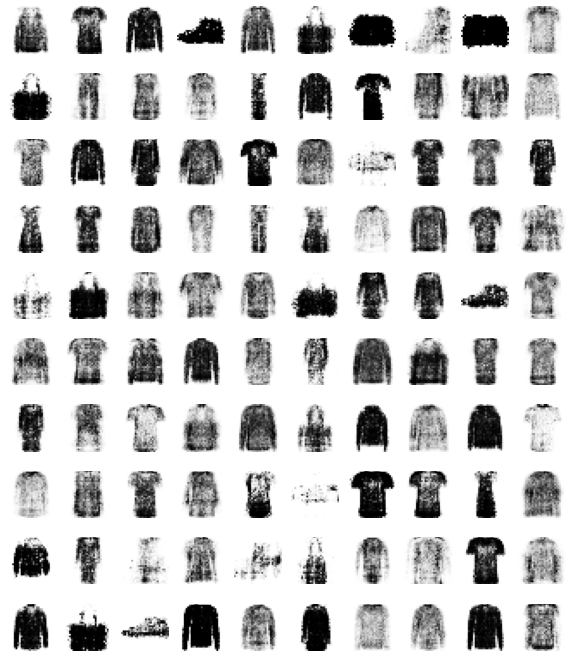

epoch: 51, discriminator loss real: 0.448880672454834, discriminator loss fake: 0.4318855404853821, gan loss: 1.504701852798462
epoch: 52, discriminator loss real: 0.48483115434646606, discriminator loss fake: 0.45100149512290955, gan loss: 1.4421257972717285
epoch: 53, discriminator loss real: 0.600261926651001, discriminator loss fake: 0.4656299948692322, gan loss: 1.3768447637557983
epoch: 54, discriminator loss real: 0.48748740553855896, discriminator loss fake: 0.4176197648048401, gan loss: 1.5781461000442505
epoch: 55, discriminator loss real: 0.46446794271469116, discriminator loss fake: 0.30245715379714966, gan loss: 1.8572522401809692
epoch: 56, discriminator loss real: 0.5321517586708069, discriminator loss fake: 0.34663739800453186, gan loss: 1.6186158657073975
epoch: 57, discriminator loss real: 0.4540998041629791, discriminator loss fake: 0.3473517596721649, gan loss: 1.5502089262008667
epoch: 58, discriminator loss real: 0.5265783071517944, discriminator loss fake: 0.4406

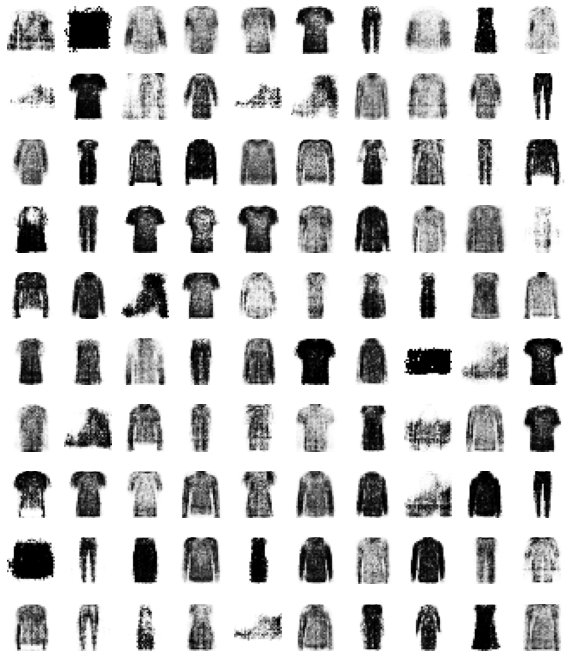

epoch: 61, discriminator loss real: 0.4624461233615875, discriminator loss fake: 0.35908329486846924, gan loss: 1.6257545948028564
epoch: 62, discriminator loss real: 0.46667373180389404, discriminator loss fake: 0.3362256586551666, gan loss: 1.7874257564544678
epoch: 63, discriminator loss real: 0.41833820939064026, discriminator loss fake: 0.26818960905075073, gan loss: 1.8409208059310913
epoch: 64, discriminator loss real: 0.39987921714782715, discriminator loss fake: 0.3526172339916229, gan loss: 1.6770458221435547
epoch: 65, discriminator loss real: 0.4793024957180023, discriminator loss fake: 0.33337709307670593, gan loss: 1.631345510482788
epoch: 66, discriminator loss real: 0.6195288300514221, discriminator loss fake: 0.5586923360824585, gan loss: 1.2105581760406494
epoch: 67, discriminator loss real: 0.496673583984375, discriminator loss fake: 0.4768698513507843, gan loss: 1.5020561218261719
epoch: 68, discriminator loss real: 0.5893539190292358, discriminator loss fake: 0.553

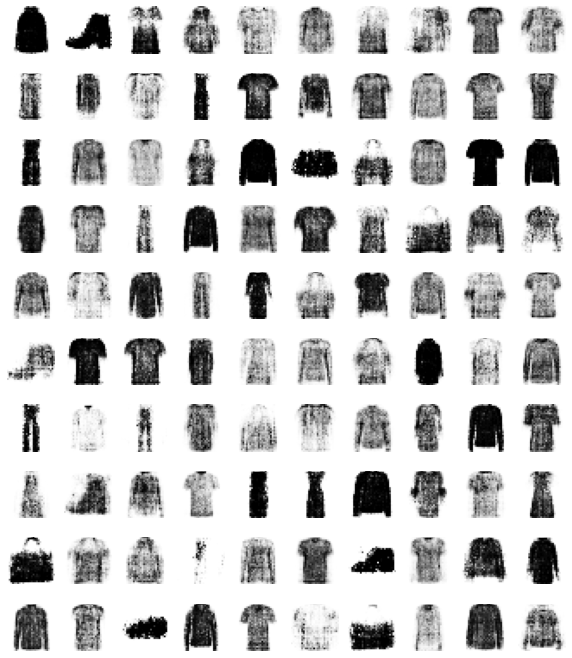

epoch: 71, discriminator loss real: 0.395160973072052, discriminator loss fake: 0.35361793637275696, gan loss: 1.8615820407867432
epoch: 72, discriminator loss real: 0.40072694420814514, discriminator loss fake: 0.3921131193637848, gan loss: 1.6628779172897339
epoch: 73, discriminator loss real: 0.40162548422813416, discriminator loss fake: 0.44271814823150635, gan loss: 1.608323097229004
epoch: 74, discriminator loss real: 0.4689023196697235, discriminator loss fake: 0.37568894028663635, gan loss: 1.7725211381912231
epoch: 75, discriminator loss real: 0.5837118029594421, discriminator loss fake: 0.5412209630012512, gan loss: 1.5234280824661255
epoch: 76, discriminator loss real: 0.5062667727470398, discriminator loss fake: 0.5152502059936523, gan loss: 1.3666119575500488
epoch: 77, discriminator loss real: 0.698314905166626, discriminator loss fake: 0.5775340795516968, gan loss: 1.3852190971374512
epoch: 78, discriminator loss real: 0.43738484382629395, discriminator loss fake: 0.3132

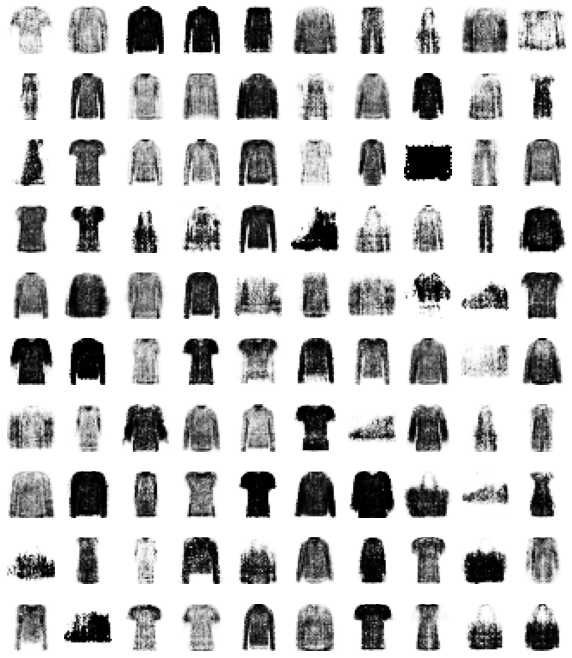

epoch: 81, discriminator loss real: 0.5437617897987366, discriminator loss fake: 0.430364727973938, gan loss: 1.606863260269165
epoch: 82, discriminator loss real: 0.5686995387077332, discriminator loss fake: 0.38606277108192444, gan loss: 1.4668275117874146
epoch: 83, discriminator loss real: 0.5543919801712036, discriminator loss fake: 0.5693331360816956, gan loss: 1.2628110647201538
epoch: 84, discriminator loss real: 0.497260719537735, discriminator loss fake: 0.39881956577301025, gan loss: 1.5607696771621704
epoch: 85, discriminator loss real: 0.597224235534668, discriminator loss fake: 0.49574652314186096, gan loss: 1.444936990737915
epoch: 86, discriminator loss real: 0.28517934679985046, discriminator loss fake: 0.2552163302898407, gan loss: 1.960237979888916
epoch: 87, discriminator loss real: 0.5733041763305664, discriminator loss fake: 0.567211925983429, gan loss: 1.4695123434066772
epoch: 88, discriminator loss real: 0.5903568863868713, discriminator loss fake: 0.4107669889

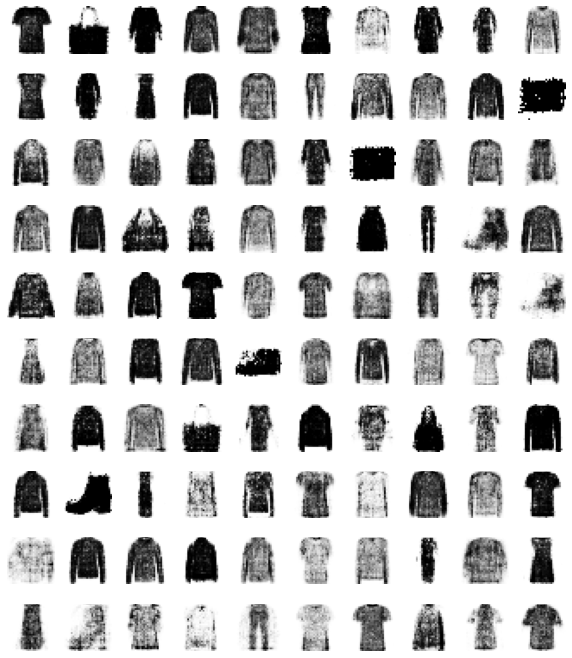

epoch: 91, discriminator loss real: 0.28670844435691833, discriminator loss fake: 0.3565335273742676, gan loss: 1.8042408227920532
epoch: 92, discriminator loss real: 0.5346144437789917, discriminator loss fake: 0.4119487702846527, gan loss: 1.384084701538086
epoch: 93, discriminator loss real: 0.4522288143634796, discriminator loss fake: 0.33064666390419006, gan loss: 1.7894333600997925
epoch: 94, discriminator loss real: 0.6422629952430725, discriminator loss fake: 0.44843602180480957, gan loss: 1.3136504888534546
epoch: 95, discriminator loss real: 0.4478326439857483, discriminator loss fake: 0.517880916595459, gan loss: 1.4972350597381592
epoch: 96, discriminator loss real: 0.5613844990730286, discriminator loss fake: 0.49798837304115295, gan loss: 1.2477110624313354
epoch: 97, discriminator loss real: 0.44374722242355347, discriminator loss fake: 0.33881646394729614, gan loss: 1.8143154382705688
epoch: 98, discriminator loss real: 0.534887969493866, discriminator loss fake: 0.5267

In [ ]:
history = train(gan, generator, discriminator, data, dim = 100, max_epochs = 100, batch_size = 128)

#### Final epoch

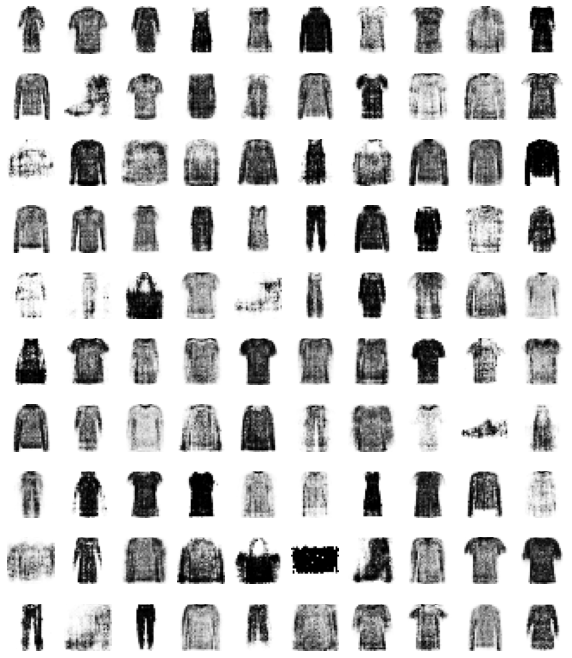

In [ ]:
pred = generator.predict(generate_noise(100, 100))
sample_images = pred.reshape(100, 28, 28)
n = 100
fig, axs = plt.subplots(10, 10, figsize=(10, 12))
axs = axs.ravel()
for z in range(n):
    axs[z].imshow(sample_images[z], cmap='gray_r')
    axs[z].axis('off')
plt.show()

#### Loss plot

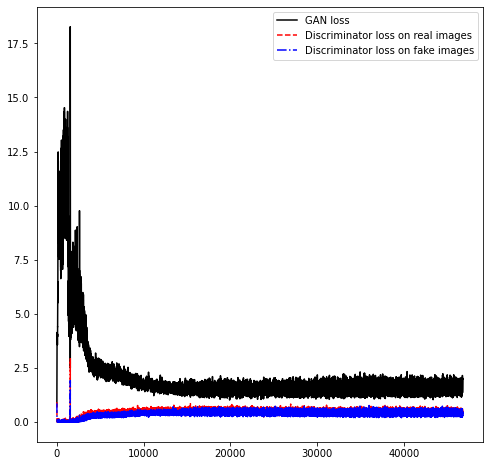

In [ ]:
hist = pd.DataFrame(history)

fig, axs = plt.subplots(figsize=(8,8))
hist['gan_loss'].plot(c='k',label='GAN loss')
hist['dis_loss_real'].plot(c='r',linestyle='--', label='Discriminator loss on real images')
hist['dis_loss_fake'].plot(c='b',linestyle='-.', label='Discriminator loss on fake images')
axs.legend()
plt.show()

## CNN-based GAN

Now we repeat everything to build CNN GAN models. The same concepts are applied, conv2d and conv2dTranspose layers are used instead of the dense layers. 

In [ ]:
def CNN_generator_model(input_dim):
  model = Sequential ([
                       Dense(7*7*128, activation=LeakyReLU(), input_shape=(input_dim,)),
                       Reshape((7, 7, 128)),
                       Conv2DTranspose(128, 5, activation=LeakyReLU(), strides=2, padding='same'),
                       Conv2DTranspose(128, 5, activation=LeakyReLU(), strides=2, padding='same'),
                       Conv2D(1, (7,7), activation='sigmoid', padding='same')
                       ])
  return model


In [ ]:
def CNN_discriminator_model(input_dim):
  model = Sequential ([
                        Conv2D(128, 5, activation=LeakyReLU(), strides=2, padding='same', input_shape=input_dim),
                        Conv2D(128, 5, activation=LeakyReLU(), strides=2 , padding='same'),
                        Flatten(),
                        Dropout(0.2),
                        Dense(1, 'sigmoid'),
                       ])
  model.compile(optimizer = Adam(learning_rate= 0.0002, beta_1 = 0.5), loss='binary_crossentropy')
  return model


In [ ]:
def cnn_gan_model(gen, disc):
  disc.trainable = False
  model = Sequential([
                      gen,
                      disc
                      ])
  model.compile(optimizer = Adam(learning_rate= 0.0002, beta_1 = 0.5), loss= 'binary_crossentropy')
  return model

In [ ]:
input_dim_disc = (28, 28, 1)
cnn_discriminator = CNN_discriminator_model(input_dim_disc)
cnn_discriminator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 14, 14, 128)       3328      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 128)         409728    
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 6272)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 6273      
Total params: 419,329
Trainable params: 419,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_dim_gen = 100
cnn_generator = CNN_generator_model(input_dim_gen)
cnn_generator.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 128)       409728    
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 128)       409728    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 1)         6273      
Total params: 1,459,201
Trainable params: 1,459,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_gan = cnn_gan_model(cnn_generator, cnn_discriminator)
cnn_gan.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 28, 28, 1)         1459201   
_________________________________________________________________
sequential_15 (Sequential)   (None, 1)                 419329    
Total params: 1,878,530
Trainable params: 1,459,201
Non-trainable params: 419,329
_________________________________________________________________


### Results of CNN GAN model

epoch: 0, discriminator loss real: 0.6541649103164673, discriminator loss fake: 0.7038804292678833, gan loss: 0.7253226041793823


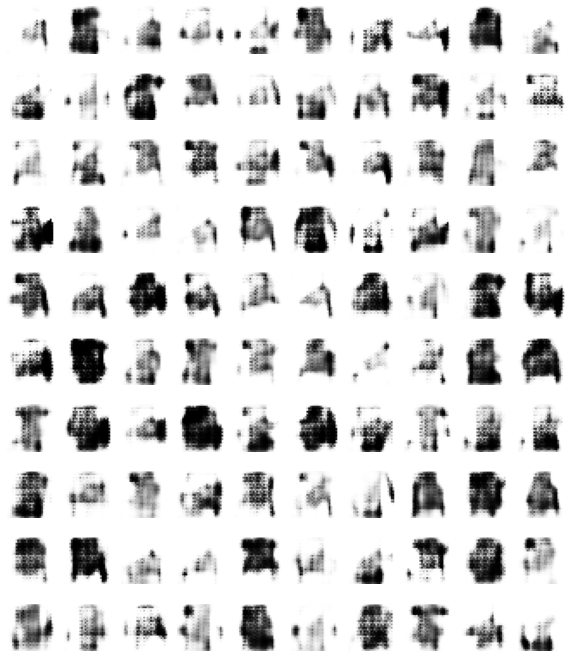

epoch: 1, discriminator loss real: 0.5775035619735718, discriminator loss fake: 0.6852972507476807, gan loss: 0.7419288754463196
epoch: 2, discriminator loss real: 0.6863747239112854, discriminator loss fake: 0.6765579581260681, gan loss: 0.7618780136108398
epoch: 3, discriminator loss real: 0.6744852066040039, discriminator loss fake: 0.7019959092140198, gan loss: 0.739033043384552
epoch: 4, discriminator loss real: 0.6999658942222595, discriminator loss fake: 0.6681777238845825, gan loss: 0.7513185143470764
epoch: 5, discriminator loss real: 0.6828607320785522, discriminator loss fake: 0.6897578835487366, gan loss: 0.7244611382484436
epoch: 6, discriminator loss real: 0.6929395794868469, discriminator loss fake: 0.6839155554771423, gan loss: 0.7373495697975159
epoch: 7, discriminator loss real: 0.6946835517883301, discriminator loss fake: 0.685954749584198, gan loss: 0.7216570973396301
epoch: 8, discriminator loss real: 0.6918214559555054, discriminator loss fake: 0.7003032565116882,

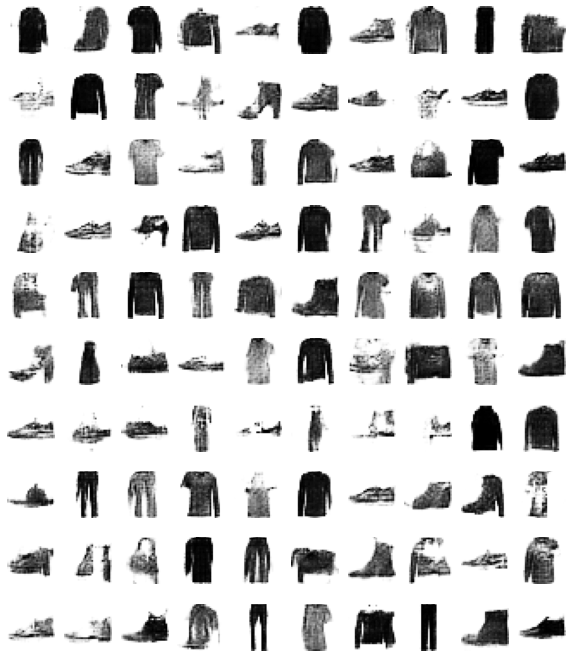

epoch: 11, discriminator loss real: 0.6951749324798584, discriminator loss fake: 0.6801870465278625, gan loss: 0.727448582649231
epoch: 12, discriminator loss real: 0.6877526044845581, discriminator loss fake: 0.6928143501281738, gan loss: 0.7191639542579651
epoch: 13, discriminator loss real: 0.6878871917724609, discriminator loss fake: 0.6939435601234436, gan loss: 0.7201341390609741
epoch: 14, discriminator loss real: 0.6844138503074646, discriminator loss fake: 0.6895310282707214, gan loss: 0.718880295753479
epoch: 15, discriminator loss real: 0.697685718536377, discriminator loss fake: 0.6913725137710571, gan loss: 0.7137148976325989
epoch: 16, discriminator loss real: 0.6869224905967712, discriminator loss fake: 0.6968429684638977, gan loss: 0.716639518737793
epoch: 17, discriminator loss real: 0.6996329426765442, discriminator loss fake: 0.6930422186851501, gan loss: 0.7292137742042542
epoch: 18, discriminator loss real: 0.683596134185791, discriminator loss fake: 0.689982414245

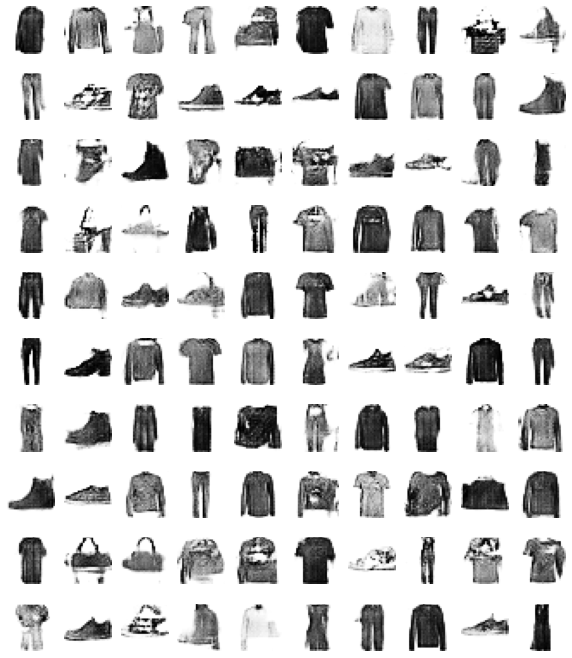

epoch: 21, discriminator loss real: 0.6863709092140198, discriminator loss fake: 0.6869603991508484, gan loss: 0.727986216545105
epoch: 22, discriminator loss real: 0.68608158826828, discriminator loss fake: 0.6864668130874634, gan loss: 0.724136233329773
epoch: 23, discriminator loss real: 0.6927906274795532, discriminator loss fake: 0.6897417306900024, gan loss: 0.7232937216758728
epoch: 24, discriminator loss real: 0.7032111883163452, discriminator loss fake: 0.6694501638412476, gan loss: 0.7219570279121399
epoch: 25, discriminator loss real: 0.7005738615989685, discriminator loss fake: 0.6925702095031738, gan loss: 0.717510461807251
epoch: 26, discriminator loss real: 0.6939927339553833, discriminator loss fake: 0.6945106387138367, gan loss: 0.7155455350875854
epoch: 27, discriminator loss real: 0.6940031051635742, discriminator loss fake: 0.6780055165290833, gan loss: 0.7287539839744568
epoch: 28, discriminator loss real: 0.6795828342437744, discriminator loss fake: 0.688629388809

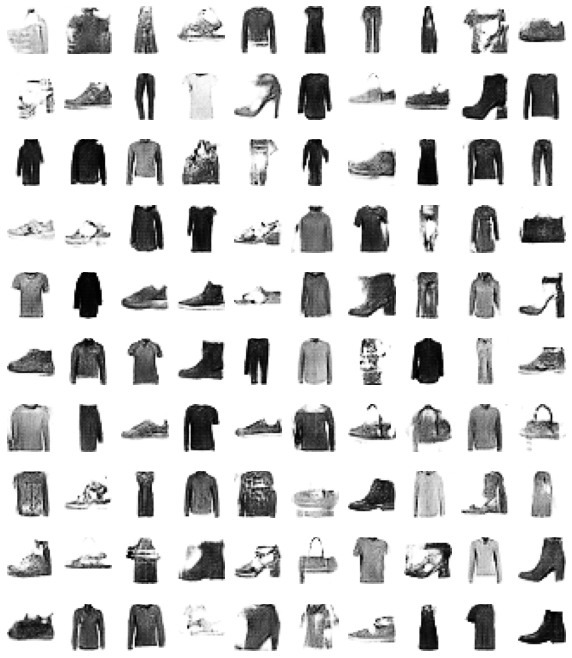

epoch: 31, discriminator loss real: 0.6882127523422241, discriminator loss fake: 0.6878513693809509, gan loss: 0.7285024523735046
epoch: 32, discriminator loss real: 0.6797512173652649, discriminator loss fake: 0.6960526704788208, gan loss: 0.7102742791175842
epoch: 33, discriminator loss real: 0.6955329179763794, discriminator loss fake: 0.6902958154678345, gan loss: 0.7198362350463867
epoch: 34, discriminator loss real: 0.6930456757545471, discriminator loss fake: 0.6868021488189697, gan loss: 0.7162831425666809
epoch: 35, discriminator loss real: 0.6845765709877014, discriminator loss fake: 0.6900584101676941, gan loss: 0.7217721343040466
epoch: 36, discriminator loss real: 0.6895287036895752, discriminator loss fake: 0.6806740164756775, gan loss: 0.7108604311943054
epoch: 37, discriminator loss real: 0.6892865896224976, discriminator loss fake: 0.6841729879379272, gan loss: 0.7227746844291687
epoch: 38, discriminator loss real: 0.6924378275871277, discriminator loss fake: 0.6779549

In [ ]:
cnn_history = train(cnn_gan, cnn_generator, cnn_discriminator, data, dim = 100, max_epochs = 40, batch_size = 128)

#### Final epoch

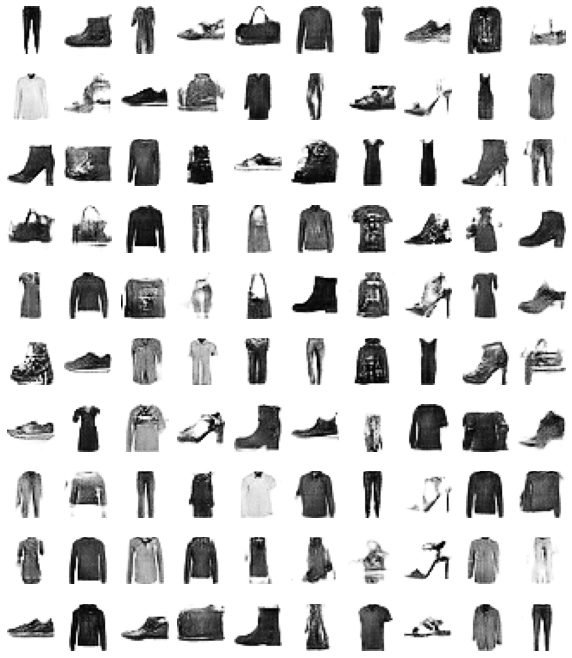

In [ ]:
pred = cnn_generator.predict(generate_noise(100, 100))
sample_images = pred.reshape(100, 28, 28)
n = 100
fig, axs = plt.subplots(10, 10, figsize=(10, 12))
axs = axs.ravel()
for z in range(n):
    axs[z].imshow(sample_images[z], cmap='gray_r')
    axs[z].axis('off')
plt.show()

#### Loss plot

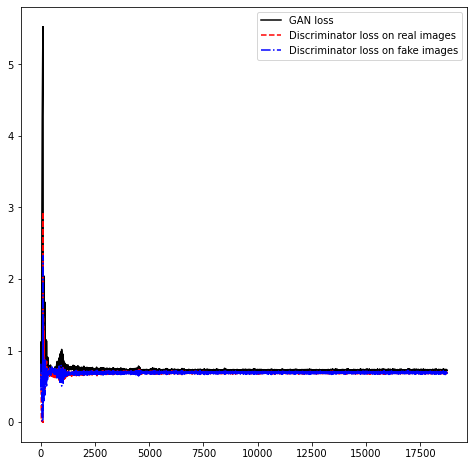

In [ ]:
cnn_hist = pd.DataFrame(cnn_history)

fig, axs = plt.subplots(figsize=(8,8))
cnn_hist['gan_loss'].plot(c='k',label='GAN loss')
cnn_hist['dis_loss_real'].plot(c='r',linestyle='--', label='Discriminator loss on real images')
cnn_hist['dis_loss_fake'].plot(c='b',linestyle='-.', label='Discriminator loss on fake images')
axs.legend()
plt.show()

## Conclusion

We can see that how output images are getting more realistic every 10 epochs, CNN model is more creative and it converged sooner so I stopped the training at 40 epochs.